In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
import csv
import sys

In [3]:
!{sys.executable} -m pip install PyAthena

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [4]:
from pyathena import connect

In [7]:
conn = connect(s3_staging_dir='s3://athena-results-c7fhgh8/',
               region_name='us-east-1')

data = pd.read_sql("select * from \"millionsongdataset-intermediate\".songdata ORDER BY RAND() LIMIT 500000", conn)

In [8]:
data.shape

(500000, 53)

In [10]:
file_name = "500kData.csv"

In [11]:
data.to_csv(file_name)

In [43]:
subset_data = data[["song_id","title","song_hotttnesss","end_of_fade_in","duration","tempo","loudness"]]
subset_data=subset_data.dropna(axis=0)

In [50]:
subset_data = subset_data.reset_index()

In [51]:
h=0.25

fig, axs = plt.subplots(1,5)

sns.kdeplot(data=subset_data['song_hotttnesss'],fill=True,  color = "#FF0000" , linewidth=1, bw_method = h , ax = axs[0])
axs[0].title.set_text('Song Hotness')

sns.kdeplot(data=subset_data['end_of_fade_in'],fill=True,  color = "#F5C63C" , linewidth=1, bw_method = h , ax = axs[1])
axs[1].title.set_text('End of Fade In')

sns.kdeplot(data=subset_data['duration'],fill=True,  color = "#5344A9" , linewidth=1, bw_method = h , ax = axs[2])
axs[2].title.set_text('Duration')

sns.kdeplot(data=subset_data['tempo'],fill=True,  color = "#329806" , linewidth=1, bw_method = h , ax = axs[3])
axs[3].title.set_text('Tempo')

sns.kdeplot(data=subset_data['loudness'],fill=True,  color = "#FF6200" , linewidth=1, bw_method = h , ax = axs[4])
axs[4].title.set_text('Loudness')

fig = plt.gcf()
fig.suptitle("Content Parameters",fontsize = 16)
fig.set_size_inches(28,5)

AttributeError: 'Line2D' object has no property 'fill'

In [ ]:
corr = subset_data.iloc[:,3:].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=20),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

fig = plt.gcf()
fig.suptitle("Correlation Matrix",fontsize = 16)
fig.set_size_inches(10,10)

In [ ]:
subset_data
Subset_X = np.array(subset_data.iloc[:,3:])

In [ ]:
scaler = StandardScaler()
scaler.fit(Subset_X)
X_Scaled = scaler.transform(Subset_X)

In [ ]:
X_Scaled[1]

In [ ]:
len(X_Scaled)

In [59]:
dist_matrix=[]
for i in X_Scaled:
    dist_list=[]
    for j in X_Scaled:
        dist = distance.euclidean(i, j, w=None)
        dist_list.append(dist)
    dist_matrix.append(dist_list)

In [75]:
dist_matrix_arr = np.array(dist_matrix)
dist_matrix_exp = np.around(dist_matrix_arr,decimals=1)

In [77]:
np.savetxt('unweighted_matrix.csv',dist_matrix_exp,delimiter=",")

In [79]:
user_input = "b'SOLXXPY12A67ADABA0'"

In [153]:
def song_recommender(user_input,subset_data,dist_matrix,rec_count):
    user_input_idx  = subset_data[subset_data["song_id"]==user_input].index.values
    user_song_dist = dist_matrix[user_input_idx].flatten(order='C')
    ind = np.argpartition(user_song_dist, -rec_count)[-rec_count:]
    opp_idx = np.flipud(ind)
    result = subset_data[["song_id","title"]].iloc[opp_idx]
    result["ranking"] = range(1,rec_count+1)
    return result

In [154]:
song_recommender(user_input,subset_data,dist_matrix_arr,10)

,song_id,title,ranking
3770,b'SOZZBDC12A8C146917',b'Fall River Legend: Conversation: Morton Goul...,1
1205,b'SOFDJER12A6D4FD361',b'Bitesize - Electro Beats Mix',2
4405,b'SODWYEY12AC468C30F',b'Endless Light',3
2534,b'SOKELFE12A6D4F7911',b'Raining Revolution (Live) (Unplugged)',4
2431,b'SOFKPLB12AC95F0493',b'The Croppy Boy',5
4141,b'SOZDWVM12A8AE448E8',b'Q Loop',6
39,b'SOJCBAM12A6701FD04',b'Paralyzed',7
387,b'SOCFKOX12A67ADAE95',b'Ghastly Indoctrination',8
2637,b'SOYUIMG12A8C135784',b'River Run',9
2898,b'SOAZOFQ12A81C20B43',b'For Abai and Togshan',10


SVD Testing

In [156]:
from numpy.linalg import svd 

In [163]:
X_ctr = X_Scaled - np.mean(X_Scaled, axis=0) 

In [164]:
U, S, Vt = svd(X_ctr)

In [181]:
Var = np.round(S**2/np.sum(S**2), decimals=3)
Var

array([0.27 , 0.218, 0.186, 0.182, 0.144])

In [183]:
np.cumsum(Var)

array([0.27 , 0.488, 0.674, 0.856, 1.   ])

In [ ]:
d=2

In [189]:
U_red = np.asarray(U[:, :2])
S_red = np.diag(S[:2])
Vt_red = Vt[:2,:]

In [256]:
from sklearn.cluster import AffinityPropagation

model = AffinityPropagation(damping=0.5, random_state=2)
model.fit(U_red)
yhat = model.predict(U_red)
clusters = np.unique(yhat)
for cluster in clusters:
	row_ix = np.where(yhat == cluster)
	plt.scatter(U_red[row_ix, 0], U_red[row_ix, 1])


fig = plt.gcf()
fig.suptitle("Affinity Propogation",fontsize = 16)
fig.set_size_inches(10,10)

plt.show()

In [235]:
damp_list=[]
cluster_list=[]
distor_list=[]
for i in np.linspace(0.5,1,10,endpoint=False):
    model = AffinityPropagation(damping=0.8, random_state=2)
    model.fit(U_red)
    yhat = model.predict(U_red)
    clusters = np.unique(yhat).shape[0]
    distortion = ((U_red - model.cluster_centers_[yhat])**2.0).sum(axis=1)
    damp_list.append(i)
    cluster_list.append(clusters)
    distor_list.append(distortion)

In [252]:
distor_list2 = np.array(distor_list)
distor_list2.shape

(10, 4629)

In [253]:
distor_list2 = np.sum(distor_list2,axis=1)
distor_list2.shape

(10,)

In [255]:
cluster_list

[92, 92, 92, 92, 92, 92, 92, 92, 92, 92]

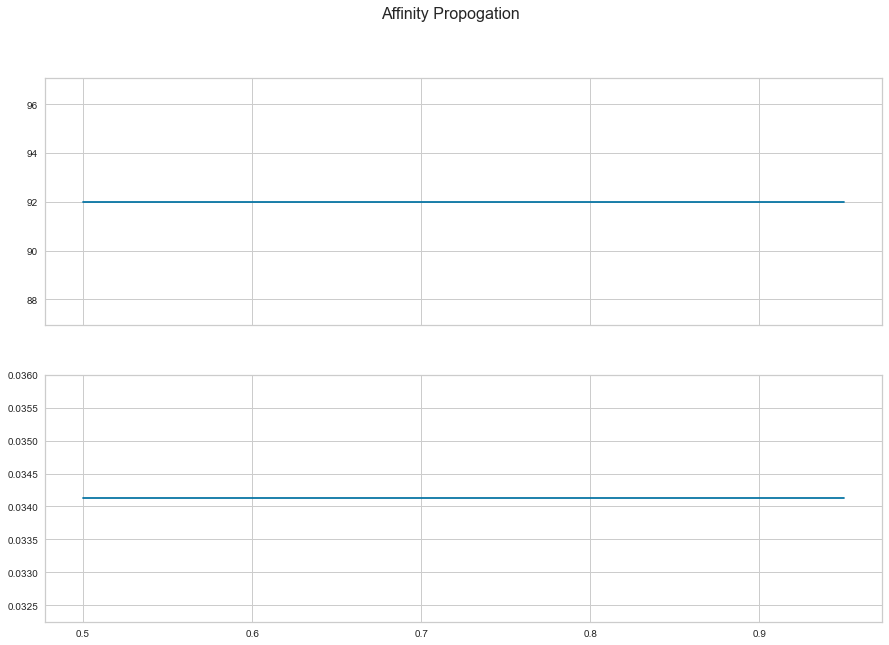

In [254]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(damp_list,cluster_list)
ax[1].plot(damp_list,distor_list2);

fig = plt.gcf()
fig.suptitle("Affinity Propogation",fontsize = 16)
fig.set_size_inches(15,10)
